#### Descreption

Σε αυτό το notebook κάνουμε την εξής διαδικασία:

Φορτώνουμε ένα target μοντέλο ήδη εκπαιδευμένο με κάποια rows από το dataset.

Τo κάνουμε evaluate για να βρούμε πώς τα πηγαίνει σε test data που δεν έχει ξαναδεί.

Στη συνέχεια έχουμε ένα shadow model το οποίο προσπαθούμε με hyperparameter tuning να το φέρουμε όσο πιο κοντά γίνεται στο target model μας.

Έπειτα δημιουργούμε το dataset για το attack model.

Για να γίνει αυτό θα πρέπει να κάνουμε ένα temp dataset το οποίο θα περιέχει μόνο rows χωρίς target column όπου θα περιέχει μισά member και μισά non-member rows. Με το temp dataset αυτό παράγουμε outputs του μοντέλου για να δημιουργήσουμε το attack training dataset και στα outputs του μοντέλου προσθέτουμε και μια boolean στήλη.

Τo dataset αυτό επόμενος το δίνουμε σε έναν binary classifier για να εκπαιδευτεί. Βλέπουμε την απόδοσή του στο shadow model και έτσι πάμε να το δοκιμάσουμε και στο trained μοντέλο.

Άρα μπορούμε να κάνουμε ένα καινούριο dataset όπου θα περιέχει 50% δεδομένα από το training dataset του target μοντέλου και 50% δεδομένα που δεν έχουν χρησιμοποιηθεί ούτε στο training του target ούτε στο training του shadow.


#### Diagram:
**Arxiko Dataset** -> Train/Test Target Model -> **Target Model Trained**

**Arxiko Dataset** -> Train/Test Shadow Model(s) -> **Shadow Model(s) Trained**

Shadow model -> predictions using it's **train** (member) and **test** (non member) data -> **Training Dataset for Attack Model** (membersip status)

**Attack Model Training Dataset** -> Train Binary Classifier -> **Attack Model Trained**



dataset cases:
Assuming target dataset is always bigger than the shadow dataset
1. target dataset is disjoined with the shadow dataset. Attack test dataset is disjoined with target and shadow
2. target dataset has some overlap with the shadow dataset. Attack test dataset is disjoined with target and shadow
3. target dataset is superset of the shadow dataset. Attack test dataset is disjoined with target and shadow


#### unzip data from tar.gz

In [1]:

!tar -xzvf "/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/dataset_purchase.tgz" -C "/content/"

!mv "/content/dataset_purchase" "/content/dataset_purchase.csv"


dataset_purchase


# Full Attack

#### Imports & Functions

In [2]:
import pandas as pd
import numpy as np
import torch
import random
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


class ShadowModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ShadowModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        return x


def train_neural_net(model, train_loader, val_loader, criterion, optimizer, epochs, patience, early_stopping = True):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss =  0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        epoch_loss = running_loss / len(train_loader)
        current_lr = scheduler.get_last_lr()[0]

        scheduler.step()

        if early_stopping:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
            val_loss /= len(val_loader)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("\nEarly stopping triggered.")
                    break
            print(f'\rEpoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning Rate: {current_lr:.8f}', end='', flush=True)
        else:
            print(f'\rEpoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f}, Learning Rate: {current_lr:.8f}', end='', flush=True)


def create_df_with_membership_status_using_model_outputs(model, member_df, non_member_df):

    ''' create a dataframe from the outputs of a model
    and add a column refering to the membership status of each record '''

    member_tensor = torch.tensor(member_df.values, dtype=torch.float32)
    non_member_tensor = torch.tensor(non_member_df.values, dtype=torch.float32)

    # use the provided model to generate outputs
    model.eval()
    member_outputs =  F.softmax(model(member_tensor), dim=1)
    non_member_outputs = F.softmax(model(non_member_tensor), dim=1)

    in_df = pd.DataFrame(member_outputs.detach().numpy())
    in_df['membership'] = True

    out_df = pd.DataFrame(non_member_outputs.detach().numpy())
    out_df['membership'] = False

    concatenated_df = pd.concat([in_df, out_df])

    return concatenated_df


#### Driver Code

Load the data. Remove from the base data all the rows that Target model was trained on and the non member rows because this will be the dataframe you will test your Attack model on. You don't want your shadow models to have seen the test data

Import Target Model and it's training dataset in order to have member and non member data rows

In [3]:
df = pd.read_csv('/content/dataset_purchase.csv')

In [13]:
SHADOW_MODEL_ROWS_RANGE = 20_000

initial_df = df.copy()

FOLDER_NAME = 'target_model_pd_1a'

folder_path = f'/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/{FOLDER_NAME}'

target_model = torch.jit.load(f'{folder_path}/target_model.pt')

X_member_df = pd.read_csv(f'{folder_path}/train_dataset.csv')
initial_df.drop(X_member_df.index, inplace=True) # remove targets train data from initial df

X_non_member_df = initial_df.sample(n=len(X_member_df)).drop(columns=initial_df.columns[0], axis=1)
initial_df.drop(X_non_member_df.index, inplace=True) # remove targets test data from initial df

dataset_from_target_model_outputs = create_df_with_membership_status_using_model_outputs(target_model, X_member_df, X_non_member_df)

shadow_model_df = initial_df.head(SHADOW_MODEL_ROWS_RANGE).copy()

print('Target Model dataset has members up to: ', max(list(X_member_df.index)))
print('target model\'s training dataset shape: ', dataset_from_target_model_outputs.shape)

print(f'\nShadow Dataset will be from: {list(shadow_model_df.index)[0] } - { list(shadow_model_df.index)[-1] }')

Target Model dataset has members up to:  35999
target model's training dataset shape:  (72000, 101)

Shadow Dataset will be from: 36001 - 61514


In [ ]:
shadow_model_df = df.iloc[60_000:80_000].copy()
print(shadow_model_df.index)

RangeIndex(start=60000, stop=80000, step=1)


In [ ]:
# check your data shapes
print(initial_df.shape, ": initial_df after member records removal")
print(X_member_df.shape,": X_member_df shape")
print(X_non_member_df.shape, ": X_non_member_df shape")
print(dataset_from_target_model_outputs.shape, ": dataset_from_target_model_outputs shape")
print(shadow_model_df["63"].nunique(), ": unique classes")

(125323, 601) : initial_df after member records removal
(36000, 600) : X_member_df shape
(36000, 600) : X_non_member_df shape
(72000, 101) : dataset_from_target_model_outputs shape
100 : unique classes


In [14]:
if __name__ == "__main__":

    set_seed(42)

    # hyperparameters shadow model
    hidden_size = 128
    learning_rate = 0.01
    lr_decay = 1e-7
    epochs = 150
    batch_size = 32
    early_stoping_patience = 3
    early_stopping=False
    number_of_shadows = 5

    df_from_shadow_model_outputs = pd.DataFrame()

    X = shadow_model_df.drop(columns=shadow_model_df.columns[0], axis=1)
    y = shadow_model_df.iloc[:, 0] - 1 # the classes in the target column are from 1 - 100. Bring them from 0 - 99

    for model_idx in tqdm(range(number_of_shadows), desc='Shadow Models Trained'):

        # each model will have a different split even after setting set_seed(42)
        # because numpy random gets consumed each time it gets used. But every time you run it, it will be
        # the same random sequence
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

        train_data = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

        test_data = TensorDataset(X_test_tensor, y_test_tensor)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

        n_features = X_train.shape[1]
        n_classes = y_train.nunique()

        shadow_model = ShadowModel(n_features, hidden_size, n_classes)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(shadow_model.parameters(), lr=learning_rate, momentum=0.9)
        scheduler = ExponentialLR(optimizer, gamma= 1 -  lr_decay)

        # optimizer = optim.Adam(shadow_model.parameters(), lr=learning_rate)

        train_neural_net(shadow_model, train_loader, test_loader, criterion,
                        optimizer, epochs, early_stoping_patience, early_stopping)

        print(f'\nGenerating data from shadow model ({model_idx}) outputs\n')

        samples = min(len(X_train), len(X_test))
        X_member_sample = X_train.sample(n=samples, replace=False)
        X_non_member_sample = X_test.sample(n=samples, replace=False)

        temp_df = create_df_with_membership_status_using_model_outputs(shadow_model, X_member_sample, X_non_member_sample)

        df_from_shadow_model_outputs = pd.concat([df_from_shadow_model_outputs, temp_df], ignore_index=True)

    print('\nRESULTING ATTACK DATA SHAPE: ', df_from_shadow_model_outputs.shape)
    # df_from_shadow_model_outputs.head(2)


Random seed set as 42


Shadow Models Trained:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 150/150 | Train Loss: 0.0065, Learning Rate: 0.00999985
Generating data from shadow model (0) outputs

Epoch 150/150 | Train Loss: 0.0064, Learning Rate: 0.00999985
Generating data from shadow model (1) outputs

Epoch 150/150 | Train Loss: 0.0065, Learning Rate: 0.00999985
Generating data from shadow model (2) outputs

Epoch 150/150 | Train Loss: 0.0064, Learning Rate: 0.00999985
Generating data from shadow model (3) outputs

Epoch 150/150 | Train Loss: 0.0065, Learning Rate: 0.00999985
Generating data from shadow model (4) outputs


RESULTING ATTACK DATA SHAPE:  (100000, 101)


#### Train the attack model

In [15]:
set_seed(42)

training_df_for_binary_classifier = shuffle(df_from_shadow_model_outputs).reset_index(drop=True) # shuffle

X_attack = training_df_for_binary_classifier.drop(columns=['membership'])
y_attack = training_df_for_binary_classifier['membership']

X_attack_train, X_attack_test, y_attack_train, y_attack_test = train_test_split(X_attack, y_attack, test_size=0.2)
attack_model = RandomForestClassifier(n_estimators=100, verbose=2)
attack_model.fit(X_attack_train, y_attack_train)

y_attack_pred = attack_model.predict(X_attack_test)
test_precision = precision_score(y_attack_test, y_attack_pred)
print("Test Precision:", test_precision)

test_accuracy = attack_model.score(X_attack_test, y_attack_test)
print("Test Accuracy:", test_accuracy)

# X_attack_train.head(2)

Random seed set as 42
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.5min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


Test Precision: 0.8260455450688371


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


Test Accuracy: 0.8764


# Test the Attack Model using predictions from the Target Model

##### Test the **attack model** on the dataset generated by the **target model**

Random seed set as 42


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


True values:  47783
False values:  24217


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


Confusion Matrix (Percentages):
[[57.35833333 42.64166667]
 [ 9.91111111 90.08888889]]
Test F1 Score: 0.7742
Test Accuracy: 0.7372
Test Precision: 0.6787
Test Recall: 0.9009


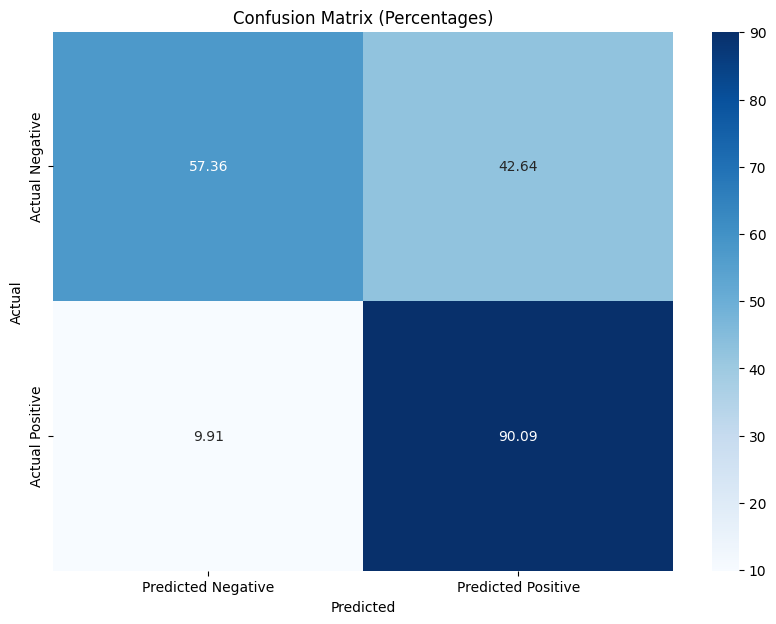

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

set_seed(42)

# TODO: Change variable names here

X_attack = dataset_from_target_model_outputs.drop(columns=['membership'])
y_attack = dataset_from_target_model_outputs['membership']

y_attack_pred = attack_model.predict(X_attack)
print("True values: ", np.count_nonzero(y_attack_pred == True))
print("False values: ", np.count_nonzero(y_attack_pred == False))

# Compute metrics
test_precision = precision_score(y_attack, y_attack_pred)
test_recall = recall_score(y_attack, y_attack_pred)
test_accuracy = attack_model.score(X_attack, y_attack)
f1 = f1_score(y_attack, y_attack_pred)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_attack, y_attack_pred)

# Convert confusion matrix to percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

print("Confusion Matrix (Percentages):")
print(conf_matrix_percent)

print(f"Test F1 Score: {f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Plot confusion matrix with percentages
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentages)')
plt.show()

#### Save attack model

In [ ]:
import joblib

folder_name = f'Unlearning'

folder_path = f"/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/{folder_name}"
os.makedirs(folder_path, exist_ok=True)

joblib.dump(attack_model, folder_path + "/attack_model_trained_with_20000_data.joblib")

['/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/Unlearning/attack_model_trained_with_20000_data.joblib']

#### Save shadow model

In [ ]:
shadow_model.eval()

typical_input = next(iter(train_loader))[0]  # Get a typical input tensor
traced_model = torch.jit.trace(shadow_model, typical_input)

# folder_name = f'target_model_with_{target_dataset_head_rows}_data'
folder_name = f'shadow_model_trained_with_40000_data_5_shadows'

folder_path = f"/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/{folder_name}"
os.makedirs(folder_path, exist_ok=True)
torch.jit.save(traced_model, folder_path + "/shadow_model.pt")

Plot ROC


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


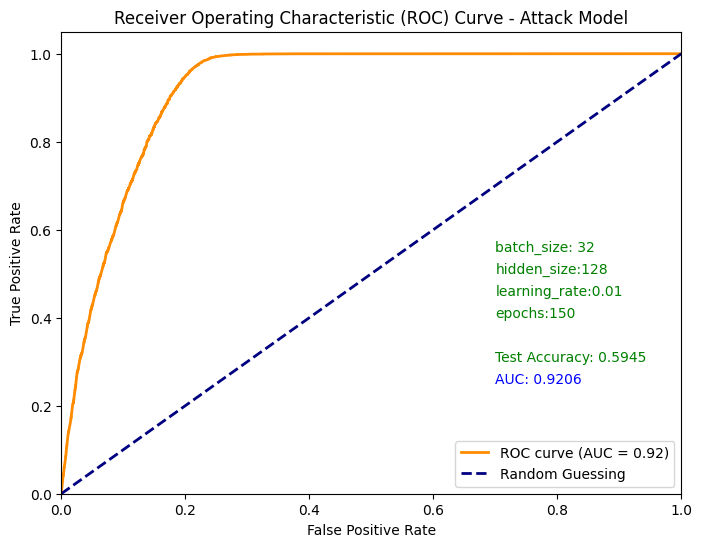

In [ ]:


# y_model_probs = attack_model.predict_proba(X_attack_test)[:, 1]

# fpr, tpr, thresholds = roc_curve(y_attack_test, y_model_probs)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve - Attack Model')
# plt.legend(loc='lower right')


# plt.text(0.7, 0.55, f'batch_size: {batch_size}' , fontsize=10, color='green')
# plt.text(0.7, 0.5, f'hidden_size:{hidden_size}' , fontsize=10, color='green')
# plt.text(0.7, 0.45, f'learning_rate:{learning_rate}', fontsize=10, color='green')
# plt.text(0.7, 0.4, f'epochs:{epochs}', fontsize=10, color='green')
# # plt.text(0.7, 0.35, f'number_of_shadows:{number_of_shadows}', fontsize=10, color='green')

# plt.text(0.7, 0.3, f'Test Accuracy: {test_accuracy:.4f}', fontsize=10, color='green')
# plt.text(0.7, 0.25, f'AUC: {roc_auc:.4f}', fontsize=10, color='blue')


# plt.show()

####ROC - plot

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s


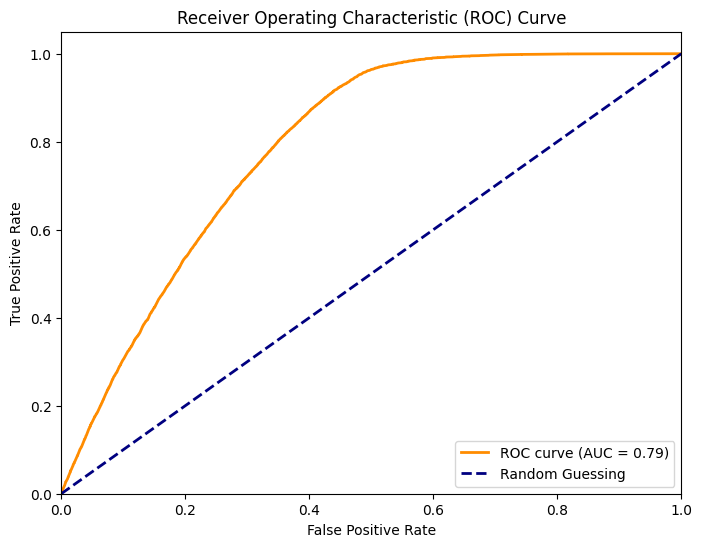

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

X_attack = dataset_from_target_model_outputs.drop(columns=['membership'])
y_attack = dataset_from_target_model_outputs['membership']

y_attack_probs = attack_model.predict_proba(X_attack)[:, 1]

fpr, tpr, thresholds = roc_curve(y_attack, y_attack_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

num_fc_layers = sum(1 for module in shadow_model.modules() if isinstance(module, nn.Linear))

# plt.text(0.7, 0.6, f'{FOLDER_NAME}', fontsize=10, color='red')
# plt.text(0.7, 0.55, f'shadow model params', fontsize=10, color='green')
# plt.text(0.7, 0.5, f'batch_size: {batch_size}' , fontsize=10, color='green')
# plt.text(0.7, 0.45, f'hidden_size:{hidden_size}' , fontsize=10, color='green')
# plt.text(0.7, 0.4, f'learning_rate:{learning_rate}', fontsize=10, color='green')
# plt.text(0.7, 0.35, f'shadow_data_size:{SHADOW_MODEL_ROWS_RANGE}', fontsize=10, color='green')
# plt.text(0.7, 0.3, f'number_of_shadows:{number_of_shadows}', fontsize=10, color='green')

# plt.text(0.7, 0.25, f'Test Accuracy: {test_accuracy:.4f}', fontsize=10, color='green')
# plt.text(0.7, 0.2, f'AUC: {roc_auc:.4f}', fontsize=10, color='blue')


plt.show()